In [2]:
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn import preprocessing
pd.set_option('display.max_colwidth', None)

In [ ]:
df = pd.read_csv("combined.csv")

In [ ]:
df.head(5)

In [ ]:
df.describe().loc["count"]

#### Normalized data

In [ ]:
def get_slices(df, column_name):
    grouped = df.groupby(column_name)
    slices = [group for _, group in grouped]
    return slices

def aggregate_slices(slice_df):
    rows_data = []
    new_slice = {
        'json_path': slice_df["path"].unique()[0],
        'image_path': slice_df["image_path"].unique()[0]
    }
    for index, row in slice_df.iterrows():
        rows_data.append([row['class_label'], row['x_center'], row['y_center'], row['upd_width'], row['upd_height']])
    new_slice.update({'new_labels': rows_data})
    return new_slice

In [ ]:
def get_normalized_xywh(df):
    result_df = pd.DataFrame()
    name_slices = get_slices(df, 'path')
    for i, slice_df in enumerate(name_slices):
        # print(f"Slice {i + 1} for {slice_df['path'].iloc[0]}:")

        df_sample = pd.DataFrame(slice_df)
    
        # Calculate normalized coordinates
        df_sample['x_center'] = (df_sample['box_x1'] + df_sample['box_x2']) / (2 * df_sample['width'])
        df_sample['y_center'] = (df_sample['box_y1'] + df_sample['box_y2']) / (2 * df_sample['height'])
        df_sample['upd_width'] = (df_sample['box_x2'] - df_sample['box_x1']) / df_sample['width']
        df_sample['upd_height'] = (df_sample['box_y2'] - df_sample['box_y1']) / df_sample['height']
        result_df = pd.concat([result_df, df_sample], ignore_index=True)
    return result_df

def agg_normalized_df(df):
    # 1. df
    result_df = pd.DataFrame()
    # 2. df
    # new_df = pd.DataFrame()
    name_slices = get_slices(df, 'path')
    
    for i, slice_df in enumerate(name_slices):
        # 3. df
        df_sample = pd.DataFrame(slice_df)
        print("slice", i)
        updated_slice = aggregate_slices(df_sample.reset_index(level=0, drop=True))
        print(len(updated_slice['new_labels']))
        new_df = pd.DataFrame([updated_slice], columns=updated_slice.keys())
        result_df = pd.concat([result_df, new_df], ignore_index=True)
    return result_df

In [ ]:
result_df = get_normalized_xywh(df)

In [ ]:
result_df

In [ ]:
# agg_normalized_df(result_df)
agg_df = agg_normalized_df(result_df)

#### Update saving paths

In [ ]:
def convert_json_path(path):
    replaced_path = os.path.join(
        './data/labels/',
        f"{os.path.splitext(os.path.basename(path))[0].replace('.','_')}.txt"
    )
    return replaced_path

def convert_img_path(path):
    base_filename, extension = os.path.splitext(os.path.basename(path))
    # print(base_filename, extension)
    if extension.lower() in ['.png', '.jpg']:
        new_filename = f"{base_filename}_{extension[1:]}.{extension[1:]}"
    replaced_path = os.path.join('./data/images/', new_filename)
    # print(replaced_path)
    return replaced_path

In [ ]:
agg_df["json_path_update"] = agg_df['json_path'].apply(convert_json_path)
agg_df["image_path_update"] =  agg_df['image_path'].apply(convert_img_path)

In [ ]:
agg_df.to_csv("converted_labels.csv")

#### * Write .txt
**STRUCTURE OF .txt FILE**

- One row per object
- Each row is class x_center y_center width height format.
- Box coordinates must be in normalized xywh format (from 0 - 1). If your boxes  are in pixels, divide x_center and width by image width, and y_center and height by image height.
- Class numbers are zero-indexed (start from 0).


In [ ]:
df = pd.read_csv("converted_labels.csv")

In [ ]:
os.makedirs("./data/images")
os.makedirs("./data/labels")

In [ ]:
def write_txt(df):
    for index, row in df.iterrows():
        list_of_lists = row['new_labels']
        txt_file_path = row['json_path_update']
    
        with open(txt_file_path, 'w') as txt_file:
            for sublist in list_of_lists:
                txt_file.write(" ".join(map(str, sublist)) + '\n')
        print(f"Saved data from row {index} to {txt_file_path}")
write_txt(df)

#### * Copy Image from source to destination

In [ ]:
def copy_images_and_update_paths(df):
    for index, row in df.iterrows():
        source_image_path = row['image_path']
        destination_image_path = row['image_path_update']
        try:
            shutil.copyfile(source_image_path, destination_image_path)
            print(f"Image copied from {source_image_path} to {destination_image_path}")

        except FileNotFoundError:
            print(f"Error: Source image not found at path {source_image_path} for row {index}")

        except Exception as e:
            print(f"Error: An unexpected error occurred - {str(e)} for row {index}")
copy_images_and_update_paths(df)

#### Test Image

In [27]:
def read_txt_file_to_dataframe(file_path):
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()
            data = [line.strip().split() for line in lines]
            df = pd.DataFrame(data, columns=['class', 'x_center', 'y_center', 'upd_width', 'upd_height'])
            return df
    except FileNotFoundError:
        print(f"Error: File not found at path {file_path}")
    except Exception as e:
        print(f"Error: An unexpected error occurred - {str(e)}")

# Example usage:
txt_file_path = "./data/labels/mms_00575_jpg.txt"
df1 = read_txt_file_to_dataframe(txt_file_path)

if result_df is not None:
    print("Contents of the file as a DataFrame:")

df1['x_center'] = df1['x_center'].astype(float)
df1['y_center'] = df1['y_center'].astype(float)
df1['upd_width'] = df1['upd_width'].astype(float)
df1['upd_height'] = df1['upd_height'].astype(float)

Contents of the file as a DataFrame:


In [30]:
df1

,class,x_center,y_center,upd_width,upd_height
0,0,0.292308,0.601227,0.026923,0.044479
1,0,0.271795,0.535660,0.012821,0.020706
2,0,0.329487,0.544862,0.016667,0.025307
3,0,0.482051,0.578988,0.021795,0.036810
4,0,0.486538,0.535276,0.014103,0.023006
5,1,0.219872,0.685966,0.066667,0.137270
6,1,0.188782,0.563650,0.026282,0.053681
7,1,0.453846,0.523006,0.012821,0.030675
8,4,0.160577,0.551764,0.016026,0.026840
9,4,0.327244,0.564801,0.019872,0.032975


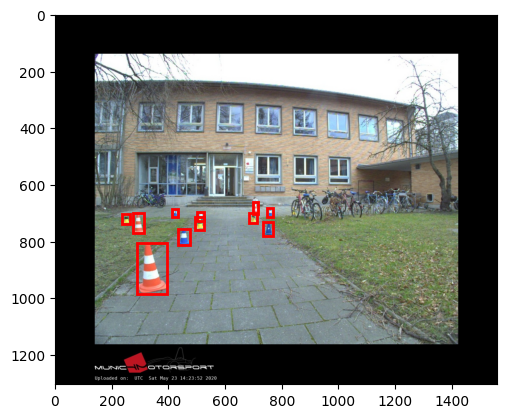

In [29]:
# Load the image (replace 'path_to_image.jpg' with your actual image path)
image_path = './data/images/mms_00575_jpg.jpg'

img = plt.imread(image_path)

# Create a figure and axis
fig, ax = plt.subplots()

# Display the image
ax.imshow(img)

img_width = 1560
img_height = 1304 
# Plot rectangles on the image using the normalized coordinates
for _, row in df1.iterrows():
    x_center = row['x_center']
    y_center = row['y_center']
    width = row['upd_width']
    height = row['upd_height']

    # Convert normalized coordinates back to pixel values
    x_center_px = x_center * img_width    #df1['width'][0]
    y_center_px = y_center * img_height   #df1['height'][0]
    width_px = width * img_width          #df1['width'][0]
    height_px = height * img_height       #df1['height'][0]

    # Create a rectangle patch
    rect = patches.Rectangle(
        (x_center_px - width_px/2, y_center_px - height_px/2),
        width_px, height_px,
        linewidth=2, edgecolor='r', facecolor='none'
    )

    # Add the rectangle patch to the axis
    ax.add_patch(rect)

# Show the image with rectangles
plt.show()

In [ ]:
# def width(df):
#     return int(df.box_x2 - df.box_x1)

# def height(df):
#     return int(df.box_y2 - df.box_y1)

# def x_center(df):
#     return int(df.box_x1 + (df.width/2))

# def y_center(df):
#     return int(df.box_y1 + (df.height/2))

# def w_norm(df, img_width):
#     return df/img_width

# def h_norm(df, img_height):
#     return df/img_height

# def get_normalized_xywh(df):
#     name_slices = get_slices(df, 'path')
#     print(name_slices[0])
#     print("length: ", len(name_slices[0]))
#     testdf = name_slices[0].reset_index(drop=True)
#     # for i, slice_df in enumerate(name_slices):
#     #     print(f"Slice {i + 1} for {slice_df['path'].iloc[0]}:")
        
#         # print(slice_df)

#     img_width = testdf['width'].iloc[0]
#     img_height = testdf['height'].iloc[0]
#     # # Label encoding for 'cell_type'
#     # le = preprocessing.LabelEncoder()
#     # le.fit(testdf['cell_type'])
#     # labels = le.transform(v['cell_type'])
#     # df1['labels'] = labels

#     # Calculate additional columns
#     df1 = pd.DataFrame()
#     df1['width'] = testdf.apply(width, axis=1)
#     df1['height'] = testdf.apply(height, axis=1)
#     df1['x_center'] = testdf.apply(x_center, axis=1)
#     df1['y_center'] = testdf.apply(y_center, axis=1)
    
#     # Normalize columns
#     df1['x_center_norm'] = df1['x_center'].apply(w_norm, img_width=img_width)
#     df1['width_norm'] = df1['width'].apply(w_norm, img_width=img_width)
#     df1['y_center_norm'] = df1['y_center'].apply(h_norm, img_height=img_height)
#     df1['height_norm'] = df1['height'].apply(h_norm, img_height=img_height)

#     #Other columns
#     df1['name'] = testdf.apply(y_center, axis=1)
#     df1['path'] = testdf.apply(y_center, axis=1)
#     df1['class_label'] = testdf.apply(y_center, axis=1)
#     df1['image_path'] = testdf.apply(y_center, axis=1)

#     return df1